# Document Overview
Created on 07/12/2020 by Cong Zhang

Read in the scaling factor and ResStock/ComStock file

In [1]:
import difflib
import string
import pandas as pd
import copy
import math
import numpy as np
from numpy import median
import os
import datetime
from Manipulate import extract_datetime_8760
import matplotlib
import glob
import re
import matplotlib.pyplot as plt
from functools import reduce
import time
from heapq import nsmallest
import seaborn as sns
%matplotlib inline

In [2]:
Region_list = ['CA','TX','NewEngland','MA']
region_id = 1  #0,1,2,3

Region = Region_list[region_id]
print('Now launch the region: ' + Region)

Switch_enduse_merged_enable = 1
# 0-each individual end use
# 1-merge the enduse to Brian's suggestions

Switch_year2016 =1
Switch_onlyResLoad_peak = 0 
# 0- looking for the peak hour of total load(default)
# 1-Only looking for the peak hour of residential load 

Switch_bottom_onlyResEE = 1
# 0- When plot step stack figure for saving shape, the bottom step line is ResEE+commercial+other (default)
# 1- When plot step stack figure for saving shape, the bottom step line is onlyResEE

Now launch the region: TX


## 0. Read in the raw files and sacling factor

In [3]:
df_res_scalingfactor = pd.read_csv('ScalingFactor(FullRun_ResStock_Data)_'+ Region +'.csv')
df_resstock = pd.read_csv('../Shared Drives/NREL_ResStock_0617/lbnl_geb_support_revamp4.csv')

In [4]:
df_com_scalingfactor = pd.read_csv('ScalingFactor(DryRun_ComStock_Data)_'+ Region +'.csv')
df_comstock_Baseline = pd.read_csv('../Shared Drives/NREL_ComStock/8760_dry_run/Converted/Baseline-8760_v4.csv')
df_comstock_Add_Lighting = pd.read_csv('../Shared Drives/NREL_ComStock/8760_dry_run/Converted/Add_Lighting_Occupancy_Controls-8760_v4.csv')
df_comstock_Upgrade_RTU = pd.read_csv('../Shared Drives/NREL_ComStock/8760_dry_run/Converted/Upgrade_RTU_DX_Air_Conditioner_IEER_17_0_-8760_v4.csv')
df_comstock_Upgrade_Roof = pd.read_csv('../Shared Drives/NREL_ComStock/8760_dry_run/Converted/Upgrade_Roof_Insulation_R_30_-8760_v4.csv')

In [5]:
def aggregate_Com_Enduse(df_com_scalingfactor,df_comstock_general):
    enduse_com_list = df_comstock_general.columns.tolist()[1:15]
    df_system_com = pd.DataFrame()

    for i in range(len(df_com_scalingfactor)):
        ws = df_com_scalingfactor.iloc[i]['weather_station']
        bt = df_com_scalingfactor.iloc[i]['building_type']
        scal_all = df_com_scalingfactor.iloc[i]['Scale_UsableRatio']*df_com_scalingfactor.iloc[i]['Scale_BuildingTot_area']*df_com_scalingfactor.iloc[i]['Scale_EIARefer']
        if scal_all ==0:
            continue 
        a = df_comstock_general[df_comstock_general['weather_station']==ws]
        b = a[a['building_type']==bt]

        for k in enduse_com_list:
            if k in df_system_com.columns:
                df_system_com[k] = list(map(lambda x: x[0]+x[1]*scal_all, zip(df_system_com[k].tolist(), b[k].tolist())))
            else:
                df_system_com[k] = b[k].tolist()
    df_system_com['month'] = b['month'].tolist()
    df_system_com['day'] = b['day'].tolist()
    df_system_com['hour'] = b['hour'].tolist()
    
    return df_system_com


def aggregate_Res_Enduse(df_res_scalingfactor,df_resstock,upgrade,df_system_com_base):
    df_resstock_general = df_resstock[df_resstock['upgrade']==upgrade]
    enduse_res_list = df_resstock.columns.tolist()[5:]
    df_system_res = pd.DataFrame()
    for i in range(len(df_res_scalingfactor)):
        ws = df_res_scalingfactor.iloc[i]['epw']
        bt = df_res_scalingfactor.iloc[i]['unit_type']
        scal_all = df_res_scalingfactor.iloc[i]['Scale_UsableRatio']*df_res_scalingfactor.iloc[i]['Scale_BuildingTot_area']*df_res_scalingfactor.iloc[i]['Scale_EIARefer']
        if scal_all ==0:
            continue 
        a = df_resstock_general[df_resstock_general['epw']==ws]
        b = a[a['unit_type']==bt]

        for k in enduse_res_list:
            if k in df_system_res.columns:
                df_system_res[k] = list(map(lambda x: x[0]+x[1]*scal_all, zip(df_system_res[k].tolist(), b[k].tolist())))
            else:
                df_system_res[k] = b[k].tolist()

    
    
    month_list = df_system_com_base['month'].tolist()
    day_list = df_system_com_base['month'].tolist()
    hour_list = df_system_com_base['month'].tolist()

    month_31 = [12 for x in range(24)]
    day_31 = [31 for x in range(24)]
    hour_31 = list(range(24))
    month_list_leap = df_system_com_base['month'].tolist() + month_31
    day_list_leap = df_system_com_base['day'].tolist() + day_31
    hour_list_leap = df_system_com_base['hour'].tolist() + hour_31

    df_system_res['month'] = month_list_leap
    df_system_res['day'] = day_list_leap
    df_system_res['hour'] = hour_list_leap
    
    day_continuous_list = []
    for day_count in range(1,367):
        day_continuous_list = day_continuous_list + [day_count for x in range(24)]
    df_system_res['day_continuous'] = day_continuous_list
    
    return df_system_res


def aggregate_Res_Enduse_merged(df_res_scalingfactor,df_resstock,upgrade,df_system_com_base):
    df_resstock_general = df_resstock[df_resstock['upgrade']==upgrade]
    enduse_res_list = df_resstock.columns.tolist()[5:]
    df_system_res = pd.DataFrame()
    for i in range(len(df_res_scalingfactor)):
        ws = df_res_scalingfactor.iloc[i]['epw']
        bt = df_res_scalingfactor.iloc[i]['unit_type']
        scal_all = df_res_scalingfactor.iloc[i]['Scale_UsableRatio']*df_res_scalingfactor.iloc[i]['Scale_BuildingTot_area']*df_res_scalingfactor.iloc[i]['Scale_EIARefer']
        if scal_all ==0:
            continue 
        a = df_resstock_general[df_resstock_general['epw']==ws]
        b = a[a['unit_type']==bt]

        for k in enduse_res_list:
            if k in df_system_res.columns:
                df_system_res[k] = list(map(lambda x: x[0]+x[1]*scal_all, zip(df_system_res[k].tolist(), b[k].tolist())))
            else:
                df_system_res[k] = b[k].tolist()

    month_list = df_system_com_base['month'].tolist()
    day_list = df_system_com_base['month'].tolist()
    hour_list = df_system_com_base['month'].tolist()

    month_31 = [12 for x in range(24)]
    day_31 = [31 for x in range(24)]
    hour_31 = list(range(24))
    month_list_leap = df_system_com_base['month'].tolist() + month_31
    day_list_leap = df_system_com_base['day'].tolist() + day_31
    hour_list_leap = df_system_com_base['hour'].tolist() + hour_31

    df_system_res['month'] = month_list_leap
    df_system_res['day'] = day_list_leap
    df_system_res['hour'] = hour_list_leap

    day_continuous_list = []
    for day_count in range(1,367):
        day_continuous_list = day_continuous_list + [day_count for x in range(24)]
    df_system_res['day_continuous'] = day_continuous_list

    df_enduse_merged_res = pd.read_csv('Inputs/Res_enduse_merged.csv')
    enduse_merged_list = df_enduse_merged_res['Aggregated display name'].unique().tolist()
    df_system_res_merged = pd.DataFrame()

    for enduse_m_id in range(len(enduse_merged_list)):
        enduse_m = enduse_merged_list[enduse_m_id]
        enduse_raw_res = df_enduse_merged_res[df_enduse_merged_res['Aggregated display name']==enduse_m]['ResStock Output'].tolist()
        for enduse_r_id in range(len(enduse_raw_res)):
            if enduse_r_id==0:
                df_system_res_merged[enduse_m] = df_system_res[enduse_raw_res[enduse_r_id]].tolist()
            else:
                tem_list = df_system_res_merged[enduse_m].tolist()
                tem_list = list(map(lambda x: x[0] +x[1],zip(tem_list,df_system_res[enduse_raw_res[enduse_r_id]].tolist())))
                df_system_res_merged[enduse_m] = tem_list   
    return df_system_res_merged

## 2. Commercial load

In [6]:
df_system_com_base = aggregate_Com_Enduse(df_com_scalingfactor,df_comstock_Baseline)

In [7]:
df_system_com_upadtedlighting = aggregate_Com_Enduse(df_com_scalingfactor,df_comstock_Add_Lighting)
df_system_com_upadtedR30 = aggregate_Com_Enduse(df_com_scalingfactor,df_comstock_Upgrade_RTU)
df_system_com_upadtedRoof = aggregate_Com_Enduse(df_com_scalingfactor,df_comstock_Upgrade_Roof)

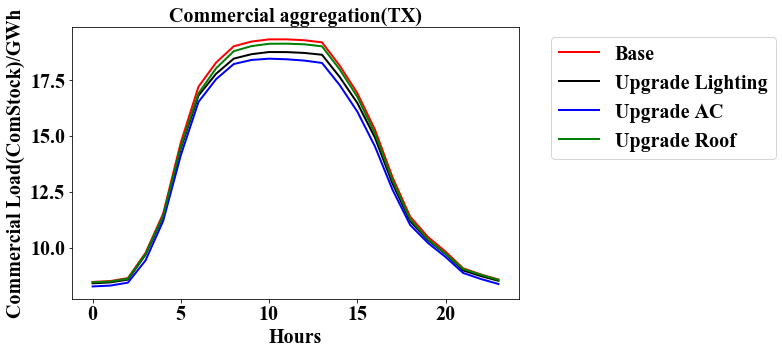

In [8]:
title_name = 'Commercial aggregation('+Region+ ')'
figsize = 8,5
figure, ax = plt.subplots(figsize=figsize)
hours= [x for x in range(0,24)]
kW_GW_multip = 0.000001

A,=plt.plot(hours,df_system_com_base.groupby('hour').mean()['out.electricity.total.energy_consumption']*kW_GW_multip,'-r',label='Base',linewidth=2.0)
B,=plt.plot(hours,df_system_com_upadtedlighting.groupby('hour').mean()['out.electricity.total.energy_consumption']*kW_GW_multip,'-k',label='Upgrade Lighting',linewidth=2.0)
C,=plt.plot(hours,df_system_com_upadtedR30.groupby('hour').mean()['out.electricity.total.energy_consumption']*kW_GW_multip,'-b',label='Upgrade AC',linewidth=2.0)
D,=plt.plot(hours,df_system_com_upadtedRoof.groupby('hour').mean()['out.electricity.total.energy_consumption']*kW_GW_multip,'-g',label='Upgrade Roof',linewidth=2.0)

font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 20,
}
font2 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 20,
}
# legend = plt.legend(handles=[A,B,C,D],prop=font1, bbox_to_anchor=[1.04,1])
legend = plt.legend(handles=[A,B,C,D],bbox_to_anchor=[1.05,1],prop=font1)

plt.tick_params(labelsize=20)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]

plt.xlabel('Hours',font2)
plt.ylabel('Commercial Load(ComStock)/GWh',font2)
plt.title(title_name,font1)
# plt.xticks([1, 3, 5,7,9,11])
plt.show()

In [9]:
kwh_TO_GWh = 0.000001
result_com = pd.DataFrame()

for upgrade in ['Baseline','Upgrade_Lighting','Upgrade_AC','Upgrade_Roof']:
    if upgrade == 'Baseline':
        df_system_com = df_system_com_base.copy()
    elif upgrade == 'Add_Lighting':
        df_system_com = df_system_com_upadtedlighting.copy()
    elif upgrade == 'Upgrade_RTU':
        df_system_com = df_system_com_upadtedR30.copy()
    elif upgrade == 'Upgrade_Roof':
        df_system_com = df_system_com_upadtedRoof.copy()
    sum_list = []
    
    for k in df_system_com.columns.tolist()[0:-3]:
        sum_list.append(df_system_com[k].sum())
        
    sum_list = [x*kwh_TO_GWh for x in sum_list]    
    result_com[upgrade] = sum_list
enduse_list = [x[16:-19] for x in df_system_com.columns.tolist()[0:-3]]
result_com.index = enduse_list

result_com.drop(index='total')
result = result_com.drop(index='total')
result.to_csv('ceshi_com.csv')

zero_env=False
fig, axs = plt.subplots(2,1, figsize=[12,10], sharex=True)
rs_map = {'CAMX':'CA', 'ERCT':'TX'}

plot_ports = ['Baseline','Upgrade_Lighting','Upgrade_AC','Upgrade_Roof']
outdir = os.path.abspath(os.getcwd())
for ax, reg in zip(axs, ['ERCT','CAMX']):
    features = result.copy()

    features[plot_ports].T.plot.bar(stacked=True, legend=False, cmap=plt.cm.get_cmap('tab20'), edgecolor='k', 
                        fontsize=16, grid=True,
                        ax=ax)
    ax.set_ylabel('End use load (GWh)', fontsize=16)
    ax.text(0.9, 0.9, rs_map[reg], transform=ax.transAxes, fontsize=20, fontweight='bold')
    
axs[1].legend(loc='lower left', bbox_to_anchor=[1.05,-0.05], fontsize=14)
plt.tight_layout()
fig.savefig(os.path.join(outdir,'features_agg_by_{g}_{r}.png'.format(g='end_use',
                                                                     r='both')),
                dpi=300)

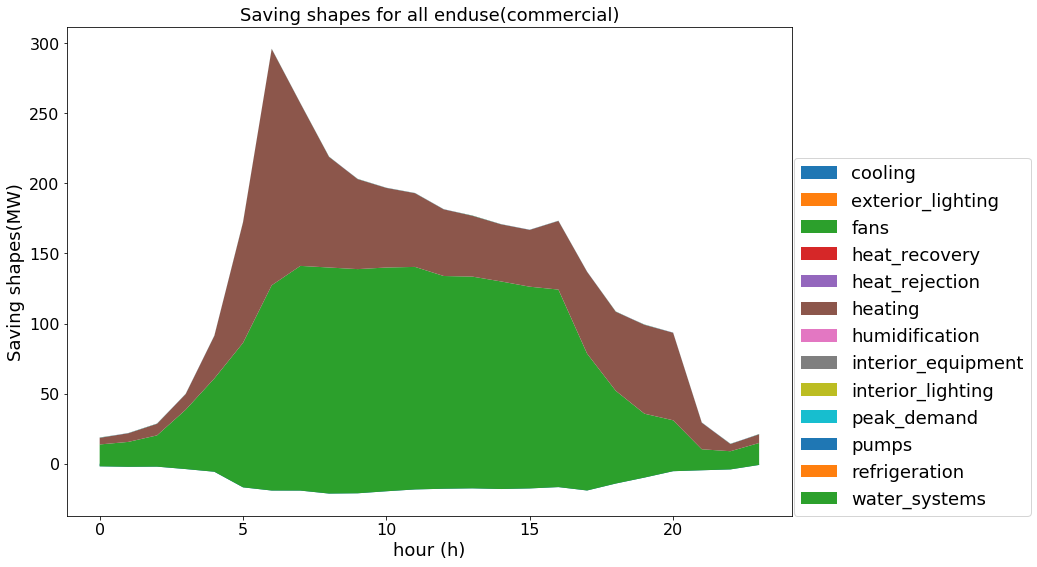

In [10]:
df_saving_com = pd.DataFrame()

for enduse in df_system_com_base.columns.tolist()[0:-3]:
    df_saving_com[enduse] = list(map(lambda x: x[0]-x[1], zip(df_system_com_base[enduse].tolist(), df_system_com_upadtedRoof[enduse].tolist())))
    
df_saving_com['hour'] = df_system_com_base['hour'].tolist()
df_saving_com = df_saving_com.drop(columns='out.electricity.total.energy_consumption')

enduse_list = df_saving_com.columns.tolist()[0:-1]
enduse_list_short = [x[16:-19] for x in enduse_list]

plt.figure(figsize=(13,9))
plt.stackplot(range(24), 
                df_saving_com.groupby('hour').mean()[enduse_list[0]]/1000, 
                df_saving_com.groupby('hour').mean()[enduse_list[1]]/1000, 
                df_saving_com.groupby('hour').mean()[enduse_list[2]]/1000, 
                df_saving_com.groupby('hour').mean()[enduse_list[3]]/1000, 
                df_saving_com.groupby('hour').mean()[enduse_list[4]]/1000, 
                df_saving_com.groupby('hour').mean()[enduse_list[5]]/1000, 
                df_saving_com.groupby('hour').mean()[enduse_list[6]]/1000, 
                df_saving_com.groupby('hour').mean()[enduse_list[7]]/1000, 
                df_saving_com.groupby('hour').mean()[enduse_list[8]]/1000, 
                df_saving_com.groupby('hour').mean()[enduse_list[9]]/1000, 
                df_saving_com.groupby('hour').mean()[enduse_list[10]]/1000, 
                df_saving_com.groupby('hour').mean()[enduse_list[11]]/1000, 
                df_saving_com.groupby('hour').mean()[enduse_list[12]]/1000,labels = enduse_list_short)

plt.legend(bbox_to_anchor=(1.002, 0), loc=3,fontsize=18, borderaxespad=0)
plt.xlabel('hour (h)',fontsize=18)
plt.ylabel('Saving shapes(MW)',fontsize=18)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16, rotation=0)
plt.title('Saving shapes for all enduse(commercial)',fontsize=18)
plt.show()

## 2. Residential load

In [11]:
if Switch_enduse_merged_enable ==1:
    df_system_res_0_raw = aggregate_Res_Enduse_merged(df_res_scalingfactor,df_resstock,0,df_system_com_base)
    df_system_res_1_raw = aggregate_Res_Enduse_merged(df_res_scalingfactor,df_resstock,1,df_system_com_base)
    df_system_res_2_raw = aggregate_Res_Enduse_merged(df_res_scalingfactor,df_resstock,2,df_system_com_base)
    df_system_res_3_raw = aggregate_Res_Enduse_merged(df_res_scalingfactor,df_resstock,3,df_system_com_base)
    df_system_res_4_raw = aggregate_Res_Enduse_merged(df_res_scalingfactor,df_resstock,4,df_system_com_base)
    df_system_res_5_raw = aggregate_Res_Enduse_merged(df_res_scalingfactor,df_resstock,5,df_system_com_base)
else:
    df_system_res_0_raw = aggregate_Res_Enduse(df_res_scalingfactor,df_resstock,0,df_system_com_base)
    df_system_res_1_raw = aggregate_Res_Enduse(df_res_scalingfactor,df_resstock,1,df_system_com_base)
    df_system_res_2_raw = aggregate_Res_Enduse(df_res_scalingfactor,df_resstock,2,df_system_com_base)
    df_system_res_3_raw = aggregate_Res_Enduse(df_res_scalingfactor,df_resstock,3,df_system_com_base)
    df_system_res_4_raw = aggregate_Res_Enduse(df_res_scalingfactor,df_resstock,4,df_system_com_base)
    df_system_res_5_raw = aggregate_Res_Enduse(df_res_scalingfactor,df_resstock,5,df_system_com_base)

## Generate the RES/COM load for NREL

In [12]:
df_system_res_0_raw.head()

Appliances       Cooling       EXCLUDE       Heating       Lighting  \
0  1.270798e+06  22644.560570  4.071234e+06  7.284130e+06  517912.580140   
1  1.137826e+06  17670.228268  3.722783e+06  7.906578e+06  310747.548084   
2  9.640572e+05  15016.750100  3.534500e+06  8.533684e+06  207165.032056   
3  9.161968e+05  13531.703508  3.430189e+06  8.982860e+06  207165.032056   
4  9.408191e+05  13454.014281  3.308921e+06  9.253331e+06  230320.896462   

           Other    Plug Loads         Total  Water Heating  month  day  hour  \
0  283983.224201  2.516453e+06  1.202203e+07  126112.618661      1    1     0   
1  257237.526698  2.327719e+06  1.207599e+07  118215.799310      1    1     1   
2  242723.978881  2.327719e+06  1.239962e+07  109257.554053      1    1     2   
3  249184.041641  2.264808e+06  1.274061e+07  106863.554230      1    1     3   
4  292027.796796  2.076074e+06  1.298184e+07  175808.859219      1    1     4   

   day_continuous  
0               1  
1               1  
2               1  
3               1  
4               1

In [13]:
df_all_res = pd.DataFrame()
df_all_res['Month'] = df_system_res_0_raw['month']
df_all_res['Day'] =   df_system_res_0_raw['day']
df_all_res['Hour'] =  df_system_res_0_raw['hour']
df_all_res['Hour_id'] =  range(len(df_system_res_0_raw))
df_all_res['RES_Base/KWh'] = df_system_res_0_raw['Total']
df_all_res['RES_EquipmentOnly/KWh'] = df_system_res_1_raw['Total']
df_all_res['RES_ControlOnly/KWh'] = df_system_res_2_raw['Total']
df_all_res['RES_EnvelopeOnly/KWh'] = df_system_res_3_raw['Total']
df_all_res['RES_Control_Envelope/KWh'] = df_system_res_4_raw['Total']
df_all_res['RES_All_Upgrades/KWh'] = df_system_res_5_raw['Total']
df_all_res.to_csv('All_Residential_load_'+Region + '.csv',index = False)


df_all_com = pd.DataFrame()
df_all_com['Month'] = df_system_com_base['month']
df_all_com['Day'] =   df_system_com_base['day']
df_all_com['Hour'] =  df_system_com_base['hour']
df_all_com['Hour_id'] =  range(len(df_system_com_base))
df_all_com['COM_Base/KWh'] = df_system_com_base['out.electricity.total.energy_consumption']
df_all_com['COM_Upgrade_lighting/KWh'] = df_system_com_upadtedlighting['out.electricity.total.energy_consumption']
df_all_com['COM_Upgrade_AC/KWh'] = df_system_com_upadtedR30['out.electricity.total.energy_consumption']
df_all_com['COM_Upgrade_Roof/KWh'] = df_system_com_upadtedRoof['out.electricity.total.energy_consumption']
df_all_com.to_csv('All_Commercial_load_'+Region + '.csv',index = False)

In [14]:
df_tem = pd.DataFrame()
scenario_list = df_all_res.columns.tolist()[4:]
scenario_list = [x[0:-4] for x in scenario_list]
df_tem['ResStock scenarios'] = scenario_list
for enduse in df_system_res_1_raw.columns.tolist()[0:-4]:    
    df_tem[enduse] = range(6)
df_tem.to_csv('All_Residential_scenario.csv',index = False)


df_tem = pd.DataFrame()
scenario_list = df_all_com.columns.tolist()[4:]
scenario_list = [x[0:-4] for x in scenario_list]
df_tem['ComStock scenarios'] = scenario_list
for enduse in df_system_com_base.columns.tolist()[0:-3]:
    df_tem[enduse[16:-19]] = range(4)
df_tem.to_csv('All_Commercial_scenario.csv',index = False)

In [15]:
df_tem


ComStock scenarios  cooling  exterior_lighting  fans  heat_recovery  \
0              COM_Base        0                  0     0              0   
1  COM_Upgrade_lighting        1                  1     1              1   
2        COM_Upgrade_AC        2                  2     2              2   
3      COM_Upgrade_Roof        3                  3     3              3   

   heat_rejection  heating  humidification  interior_equipment  \
0               0        0               0                   0   
1               1        1               1                   1   
2               2        2               2                   2   
3               3        3               3                   3   

   interior_lighting  peak_demand  pumps  refrigeration  total  water_systems  
0                  0            0      0              0      0              0  
1                  1            1      1              1      1              1  
2                  2            2      2              2      2              2  
3                  3            3      3              3      3              3

## 3. Read in the EIA measured load data

In [16]:
if region_id==0:
    CA_load_measured = pd.read_csv('Inputs/Demand_for_California_(region)_hourly_-_local_time.csv')
    CA_load_measured = CA_load_measured.rename(columns={'Demand for California (region) hourly - local time': 'Time','Unnamed: 1':'Load/MW'})
    IID_load_measured = pd.read_csv('Inputs/Demand_for_Imperial_Irrigation_District_hourly_local_time.csv')
    IID_load_measured = IID_load_measured.rename(columns={'Demand for Imperial Irrigation District (IID) hourly - local time': 'Time','Unnamed: 1':'Load/MW'})
elif region_id==1:
    CA_load_measured = pd.read_csv('Inputs/Demand_for_Texas_(region)_hourly_-_local_time.csv')
    CA_load_measured = CA_load_measured.rename(columns={'Demand for Texas (region) hourly - local time': 'Time','Unnamed: 1':'Load/MW'})
elif region_id==2:
    CA_load_measured = pd.read_csv('Inputs/Demand_for_New_England_(region)_hourly_-_local_time.csv')
    CA_load_measured = CA_load_measured.rename(columns={'Demand for New England (region) hourly - local time': 'Time','Unnamed: 1':'Load/MW'})
    
CA_load_measured = CA_load_measured.iloc[4:]
CA_load_measured_copy = CA_load_measured.copy()

time_list = CA_load_measured_copy['Time']
newcolumn_list = [datetime.datetime.strptime(x, '%m/%d/%y %H:%M') for x in time_list]
CA_load_measured_copy['Time_dateframe'] = newcolumn_list

if region_id==0:
    IID_load_measured = IID_load_measured.fillna(0)
    IID_load_measured = IID_load_measured.iloc[4:]
    IID_load_measured_copy = IID_load_measured.copy()

    time_list = IID_load_measured_copy['Time']
    newcolumn_list2 = [datetime.datetime.strptime(x, '%m/%d/%y %H:%M') for x in time_list]
    IID_load_measured_copy['Time_dateframe'] = newcolumn_list2
    IID_load_measured_copy.sort_values(by=['Time_dateframe'], inplace=True)
CA_load_measured_copy.sort_values(by=['Time_dateframe'], inplace=True)
if Switch_year2016 ==1:
    yearly_data = CA_load_measured_copy[(CA_load_measured_copy['Time_dateframe'] >= '2016-1-1') & (CA_load_measured_copy['Time_dateframe'] <= '2017-01-01')]
    yearly_data = yearly_data.iloc[1:]
    if region_id==0:
        yearly_data_IID = IID_load_measured_copy[(IID_load_measured_copy['Time_dateframe'] >= '2016-1-1') & (IID_load_measured_copy['Time_dateframe'] <= '2017-01-01')]
        yearly_data_IID = yearly_data_IID.iloc[1:]
        load_list = [int(x) for x in yearly_data['Load/MW'].tolist()]
        a = yearly_data['Time_dateframe'].tolist()
        for i in range(len(yearly_data_IID)):            
            index_time = a.index(yearly_data_IID.iloc[i][2])
            load_list[index_time] = load_list[index_time]-int(yearly_data_IID.iloc[i][1])
        yearly_data['Load/MW'] = load_list
        
    tem_list = yearly_data['Load/MW']  
    tem_list = [int(x) for x in tem_list]
    yearly_data['Load/MW'] = tem_list

In [17]:
yearly_data['day_continuous'] = df_system_res_0_raw['day_continuous'].tolist()
yearly_data['month'] = df_system_res_0_raw['month'].tolist()
yearly_data['day'] = df_system_res_0_raw['day'].tolist()
yearly_data['hour'] = df_system_res_0_raw['hour'].tolist()
yearly_data = yearly_data.rename(columns={'Load/MW': 'Total'})

In [18]:
def peak_dayly_selection(df_system_res_0):
    a = df_system_res_0.groupby('day_continuous').sum()
    day_continuous_id = a.index[a['Total'].tolist().index(max(a['Total']))]
    df_system_res_0 = df_system_res_0[df_system_res_0['day_continuous']==day_continuous_id]
    return df_system_res_0

def peak_hourly_selection(df_system_res_0):
    a = df_system_res_0.copy()
    hour_id = a.index[a['Total'].tolist().index(max(a['Total']))]
    day_continuous_id = a.loc[hour_id,'day_continuous']
    df_system_res_0 = a[a['day_continuous']==int(day_continuous_id)]
    print('The max load is ' + str(max(a['Total'])) + ', The time is: ' + str(int(a.loc[hour_id,'month'])) + '-' + str(int(a.loc[hour_id,'day'])) +'-' +str(int(a.loc[hour_id,'hour']))+'(month-day-hour)')
    return df_system_res_0, day_continuous_id
outdir = os.path.abspath(os.getcwd())

In [19]:
# # Backup
# # for season in ['Spring','Summer','Fall','Winter','All year']:
# for season in ['All year']:    
#     if season == 'Spring':
#         month_list = [3,4,5] 
#     elif season == 'Summer':
#         month_list = [6,7,8] 
#     elif season == 'Fall':
#         month_list = [9,10,11] 
#     elif season == 'Winter':
#         month_list = [12,1,2] 
#     print('The season is: ' + season)
#     if season != 'All year':
#         df_system_res_0 = pd.concat([df_system_res_0_raw[df_system_res_0_raw['month']==month_list[0]],df_system_res_0_raw[df_system_res_0_raw['month']==month_list[1]],df_system_res_0_raw[df_system_res_0_raw['month']==month_list[2]]])
#         df_system_res_1 = pd.concat([df_system_res_1_raw[df_system_res_1_raw['month']==month_list[0]],df_system_res_1_raw[df_system_res_1_raw['month']==month_list[1]],df_system_res_1_raw[df_system_res_1_raw['month']==month_list[2]]])
#         df_system_res_2 = pd.concat([df_system_res_2_raw[df_system_res_2_raw['month']==month_list[0]],df_system_res_2_raw[df_system_res_2_raw['month']==month_list[1]],df_system_res_2_raw[df_system_res_2_raw['month']==month_list[2]]])
#         df_system_res_3 = pd.concat([df_system_res_3_raw[df_system_res_3_raw['month']==month_list[0]],df_system_res_3_raw[df_system_res_3_raw['month']==month_list[1]],df_system_res_3_raw[df_system_res_3_raw['month']==month_list[2]]])
#         df_system_res_4 = pd.concat([df_system_res_4_raw[df_system_res_4_raw['month']==month_list[0]],df_system_res_4_raw[df_system_res_4_raw['month']==month_list[1]],df_system_res_4_raw[df_system_res_4_raw['month']==month_list[2]]])
#         df_system_res_5 = pd.concat([df_system_res_5_raw[df_system_res_5_raw['month']==month_list[0]],df_system_res_5_raw[df_system_res_5_raw['month']==month_list[1]],df_system_res_5_raw[df_system_res_5_raw['month']==month_list[2]]])
#     else:
#         df_system_res_0 = df_system_res_0_raw.copy()
#         df_system_res_1 = df_system_res_1_raw.copy()
#         df_system_res_2 = df_system_res_2_raw.copy()
#         df_system_res_3 = df_system_res_3_raw.copy()
#         df_system_res_4 = df_system_res_4_raw.copy()
#         df_system_res_5 = df_system_res_5_raw.copy()
        
#     if Switch_peakday ==1:
#         df_system_res_0 = peak_hourly_selection(df_system_res_0)
#         df_system_res_1 = peak_hourly_selection(df_system_res_1)
#         df_system_res_2 = peak_hourly_selection(df_system_res_2)
#         df_system_res_3 = peak_hourly_selection(df_system_res_3)
#         df_system_res_4 = peak_hourly_selection(df_system_res_4)
#         df_system_res_5 = peak_hourly_selection(df_system_res_5)
        
#     if Switch_peakday ==1:
#         title_name = 'Residential aggregation('+Region+', ' + season+ ', peakday)' 
#     else:
#         title_name = 'Residential aggregation('+Region+', ' + season+ ', average)' 
        
#     # Figure 1
#     figsize = 12,9
#     figure, ax = plt.subplots(figsize=figsize)
#     hours= [x for x in range(0,24)]
#     kW_GW_multip = 0.000001

#     A,=plt.plot(hours,df_system_res_0.groupby('hour').mean()['Total']*kW_GW_multip,'-r',label='Baseline',linewidth=2.0)
#     B,=plt.plot(hours,df_system_res_1.groupby('hour').mean()['Total']*kW_GW_multip,'-b',label='Equipment only',linewidth=2.0)
#     C,=plt.plot(hours,df_system_res_2.groupby('hour').mean()['Total']*kW_GW_multip,'-k',label='Controls only',linewidth=2.0)
#     D,=plt.plot(hours,df_system_res_3.groupby('hour').mean()['Total']*kW_GW_multip,'-g',label='Envelope only',linewidth=2.0)
#     E,=plt.plot(hours,df_system_res_4.groupby('hour').mean()['Total']*kW_GW_multip,'--r',label='Envelope + Controls',linewidth=2.0)
#     F,=plt.plot(hours,df_system_res_5.groupby('hour').mean()['Total']*kW_GW_multip,'--b',label='All Measures',linewidth=2.0)

#     font1 = {'family' : 'Times New Roman',
#     'weight' : 'normal',
#     'size'   : 20,
#     }
#     font2 = {'family' : 'Times New Roman',
#     'weight' : 'normal',
#     'size'   : 20,
#     }
#     # legend = plt.legend(handles=[A,B,C,D],prop=font1, bbox_to_anchor=[1.04,1])
#     legend = plt.legend(handles=[A,B,C,D,E,F],bbox_to_anchor=[1.05,1],prop=font1,)

#     plt.tick_params(labelsize=20)
#     labels = ax.get_xticklabels() + ax.get_yticklabels()
#     [label.set_fontname('Times New Roman') for label in labels]

#     plt.xlabel('Hours',font2)
#     plt.ylabel('Residential Load(ResStock)/GWh',font2)
#     plt.title(title_name,font1)
#     plt.xlim((0, 23)) 
#     plt.show()


#     kwh_TO_GWh = 0.000001
#     result_com = pd.DataFrame()

#     for upgrade in ['Baseline','Equipment only','Controls only','Envelope only','Envelope + Controls','All Measures']:
#         if upgrade == 'Baseline':
#             df_system_com = df_system_res_0.copy()
#         elif upgrade == 'Equipment only':
#             df_system_com = df_system_res_1.copy()
#         elif upgrade == 'Controls only':
#             df_system_com = df_system_res_2.copy()
#         elif upgrade == 'Envelope only':
#             df_system_com = df_system_res_3.copy()
#         elif upgrade == 'Envelope + Controls':
#             df_system_com = df_system_res_4.copy()
#         elif upgrade == 'All Measures':
#             df_system_com = df_system_res_5.copy()        
#         sum_list = []

#         for k in df_system_res_0.columns.tolist()[0:-1]:
#             sum_list.append(df_system_com[k].sum())

#         sum_list = [x*kwh_TO_GWh for x in sum_list]    
#         result_com[upgrade] = sum_list
#     enduse_list = [x for x in df_system_res_0.columns.tolist()[0:-1]]
#     result_com.index = enduse_list

#     result1 = result_com.drop(index='Total')
#     result = result1.drop(index='EXCLUDE')

#     zero_env=False
#     fig, axs = plt.subplots(2,1, figsize=[12,10], sharex=True)
#     rs_map = {'CAMX':'CA', 'ERCT':'TX'}

#     # Figure 2
#     plot_ports = ['Baseline','Equipment only','Controls only','Envelope only','Envelope + Controls','All Measures']
# #     plot_ports = ['Baseline','Upgrade_1','Upgrade_2','Upgrade_3','Upgrade_4','Upgrade_5']
#     outdir = os.path.abspath(os.getcwd())
#     for ax, reg in zip(axs, ['ERCT','CAMX']):
#         features = result.copy()
#         features = features.drop(index=['month','day','hour'])
#         features[plot_ports].T.plot.bar(stacked=True, legend=False, cmap=plt.cm.get_cmap('tab20'), edgecolor='k', 
#                             fontsize=16, grid=False,
#                             ax=ax)
#         ax.set_ylabel('End use load (GWh)', fontsize=16)
#         ax.text(0.9, 0.9, rs_map[reg], transform=ax.transAxes, fontsize=20, fontweight='bold')

#     axs[1].legend(loc='lower left', bbox_to_anchor=[1.05,-0.1], fontsize=14)
#     if Switch_peakday ==1:
#         plt.title('features agg by enduse(residential, '+Region+', ' + season+ ', peakday)' ,fontsize=18)
#     else:
#         plt.title('features agg by enduse(residential, '+Region+', ' + season+ ', average)' ,fontsize=18)        
#     plt.tight_layout()
#     fig.savefig(os.path.join(outdir,'features_agg_by_{g}_{r}.png'.format(g='end_use',
#                                                                          r='both')),
#                     dpi=300)


#     # Figure 3
#     df_saving_res = pd.DataFrame()
#     for enduse in df_system_res_0.columns.tolist()[0:-2]:
#         df_saving_res[enduse] = list(map(lambda x: x[0]-x[1], zip(df_system_res_0[enduse].tolist(), df_system_res_1[enduse].tolist())))

#     df_saving_res['hour'] = df_system_res_0['hour'].tolist()
#     df_saving_res = df_saving_res.drop(columns=['Total','EXCLUDE'])

#     enduse_list = df_saving_res.columns.tolist()[0:-1]
#     enduse_list_short = [x for x in enduse_list]

#     enduse_list_short_new = ['equipment only']+enduse_list_short
#     plt.figure(figsize=(13,9))
#     if Switch_enduse_merged_enable ==1:
#         plt.plot([],[],color='white', label=enduse_list_short_new[0], linewidth=3)
#         plt.plot([],[],color='blue', label=enduse_list_short_new[1], linewidth=3)
#         plt.plot([],[],color='red', label=enduse_list_short_new[2], linewidth=3)
#         plt.plot([],[],color='pink', label=enduse_list_short_new[3], linewidth=3)
#         plt.plot([],[],color='green', label=enduse_list_short_new[4], linewidth=3)
#         plt.plot([],[],color='cyan', label=enduse_list_short_new[5], linewidth=3)
#         plt.plot([],[],color='grey', label=enduse_list_short_new[6], linewidth=3)
#         plt.plot([],[],color='black', label=enduse_list_short_new[7], linewidth=3)
        
#         plt.stackplot(range(24),
#                         df_system_res_1.groupby('hour').mean()['Total']/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list_short_new[1]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list_short_new[2]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list_short_new[3]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list_short_new[4]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list_short_new[5]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list_short_new[6]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list_short_new[7]]/1000, colors=['white','blue','red','pink','green','cyan','grey','black'])
    
#     else:
#         plt.stackplot(range(24), 
#                         df_system_res_1.groupby('hour').mean()['Total']/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list[0]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list[1]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list[2]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list[3]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list[4]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list[5]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list[6]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list[7]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list[8]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list[9]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list[10]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list[11]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list[12]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list[13]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list[14]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list[15]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list[16]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list[17]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list[18]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list[19]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list[20]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list[21]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list[22]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list[23]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list[24]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list[25]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list[26]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list[27]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list[28]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list[29]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list[30]]/1000,labels = enduse_list_short_new)
        
# #     plt.step(range(24),df_system_res_1.groupby('hour').mean()['Total']/1000,color = 'black', label='EE')
#     plt.plot(range(24),df_system_res_1.groupby('hour').mean()['Total']/1000,color = 'red', label='EE-1')
#     plt.plot(range(24),df_system_res_0.groupby('hour').mean()['Total']/1000,color = 'black', label='baseline')
    
#     plt.legend(bbox_to_anchor=(1.002, 0), loc=3,fontsize=18, borderaxespad=0)
#     plt.xlabel('hour (h)',fontsize=18)
#     plt.ylabel('Saving shapes(MW)',fontsize=18)
#     plt.xlim((0, 23)) 
#     plt.xticks(fontsize=16, rotation=0)
#     plt.yticks(fontsize=16, rotation=0)    
#     if Switch_peakday ==1:
#         plt.title('Stack plot for basiline and equipment only scenario(residential, '+Region+', ' + season+ ', peakday)' ,fontsize=18)
#     else:
#         plt.title('Stack plot for basiline and equipment only scenario(residential, '+Region+', ' + season+ ', average)' ,fontsize=18)        
#     plt.show()
    
        
#     # Figure 4
#     plt.figure(figsize=(13,9))
#     if Switch_enduse_merged_enable ==1:
#         plt.plot([],[],color='blue', label=enduse_list_short_new[1], linewidth=3)
#         plt.plot([],[],color='red', label=enduse_list_short_new[2], linewidth=3)
#         plt.plot([],[],color='pink', label=enduse_list_short_new[3], linewidth=3)
#         plt.plot([],[],color='green', label=enduse_list_short_new[4], linewidth=3)
#         plt.plot([],[],color='cyan', label=enduse_list_short_new[5], linewidth=3)
#         plt.plot([],[],color='grey', label=enduse_list_short_new[6], linewidth=3)
#         plt.plot([],[],color='black', label=enduse_list_short_new[7], linewidth=3)
        
#         plt.stackplot(range(24),
#                         df_saving_res.groupby('hour').mean()[enduse_list_short_new[1]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list_short_new[2]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list_short_new[3]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list_short_new[4]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list_short_new[5]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list_short_new[6]]/1000, 
#                         df_saving_res.groupby('hour').mean()[enduse_list_short_new[7]]/1000, colors=['blue','red','pink','green','cyan','grey','black'])
    
#     plt.legend(bbox_to_anchor=(1.002, 0), loc=3,fontsize=18, borderaxespad=0)
#     plt.xlabel('hour (h)',fontsize=18)
#     plt.ylabel('Saving shapes(MW)',fontsize=18)
#     plt.xlim((0, 23)) 
#     plt.xticks(fontsize=16, rotation=0)
#     plt.yticks(fontsize=16, rotation=0)
#     if Switch_peakday ==1:
#         plt.title('Stack plot for saving shapes(residential, '+Region+', ' + season+ ', peakday)' ,fontsize=18)
#     else:
#         plt.title('Stack plot for saving shapes(residential, '+Region+', ' + season+ ', average)' ,fontsize=18)        
#     plt.show()
    
#     print('For '+season+', its min/max/average value of saving load:')
#     for i in range(1,8):
#         print('    '+enduse_list_short_new[i] + ',        min:'+str(round(min(df_saving_res.groupby('hour').mean()[enduse_list[i]]/1000),2))+ 'GW'+
#               ',          max is '+ str(round(max(df_saving_res.groupby('hour').mean()[enduse_list[i]]/1000),2))+ 'GW'+
#              ',         average is '+ str(round(np.average(df_saving_res.groupby('hour').mean()[enduse_list[i]]/1000),2))+ 'GW')


In [20]:
# # backup launch
# # for season in ['Spring','Summer','Fall','Winter','All year']:
# for season in ['Spring']: 
#     if season == 'Spring':
#         month_list = [3,4,5] 
#     elif season == 'Summer':
#         month_list = [6,7,8] 
#     elif season == 'Fall':
#         month_list = [9,10,11] 
#     elif season == 'Winter':
#         month_list = [12,1,2] 
#     print('The season is: ' + season)
#     if season != 'All year':
#         df_system_res_0 = pd.concat([df_system_res_0_raw[df_system_res_0_raw['month']==month_list[0]],df_system_res_0_raw[df_system_res_0_raw['month']==month_list[1]],df_system_res_0_raw[df_system_res_0_raw['month']==month_list[2]]])
#         df_system_res_1 = pd.concat([df_system_res_1_raw[df_system_res_1_raw['month']==month_list[0]],df_system_res_1_raw[df_system_res_1_raw['month']==month_list[1]],df_system_res_1_raw[df_system_res_1_raw['month']==month_list[2]]])
#         df_system_res_2 = pd.concat([df_system_res_2_raw[df_system_res_2_raw['month']==month_list[0]],df_system_res_2_raw[df_system_res_2_raw['month']==month_list[1]],df_system_res_2_raw[df_system_res_2_raw['month']==month_list[2]]])
#         df_system_res_3 = pd.concat([df_system_res_3_raw[df_system_res_3_raw['month']==month_list[0]],df_system_res_3_raw[df_system_res_3_raw['month']==month_list[1]],df_system_res_3_raw[df_system_res_3_raw['month']==month_list[2]]])
#         df_system_res_4 = pd.concat([df_system_res_4_raw[df_system_res_4_raw['month']==month_list[0]],df_system_res_4_raw[df_system_res_4_raw['month']==month_list[1]],df_system_res_4_raw[df_system_res_4_raw['month']==month_list[2]]])
#         df_system_res_5 = pd.concat([df_system_res_5_raw[df_system_res_5_raw['month']==month_list[0]],df_system_res_5_raw[df_system_res_5_raw['month']==month_list[1]],df_system_res_5_raw[df_system_res_5_raw['month']==month_list[2]]])
#     else:
#         df_system_res_0 = df_system_res_0_raw.copy()
#         df_system_res_1 = df_system_res_1_raw.copy()
#         df_system_res_2 = df_system_res_2_raw.copy()
#         df_system_res_3 = df_system_res_3_raw.copy()
#         df_system_res_4 = df_system_res_4_raw.copy()
#         df_system_res_5 = df_system_res_5_raw.copy()
        
#     if Switch_peakday ==1:
#         keyword = 'peakday'
#         df_system_res_0, day_id = peak_hourly_selection(df_system_res_0)
#         df_system_res_1 = df_system_res_1[df_system_res_1['day_continuous']==int(day_id)]
#         df_system_res_2 = df_system_res_2[df_system_res_2['day_continuous']==int(day_id)]
#         df_system_res_3 = df_system_res_3[df_system_res_3['day_continuous']==int(day_id)]
#         df_system_res_4 = df_system_res_4[df_system_res_4['day_continuous']==int(day_id)]
#         df_system_res_5 = df_system_res_5[df_system_res_5['day_continuous']==int(day_id)]
#     else:
#         keyword = 'average'
#         df_system_res_0 = df_system_res_0.groupby('hour').mean()
#         df_system_res_1 = df_system_res_1.groupby('hour').mean()
#         df_system_res_2 = df_system_res_2.groupby('hour').mean()
#         df_system_res_3 = df_system_res_3.groupby('hour').mean()
#         df_system_res_4 = df_system_res_4.groupby('hour').mean()
#         df_system_res_5 = df_system_res_5.groupby('hour').mean() 
#         df_system_res_0.index.names = ['index']
#         df_system_res_1.index.names = ['index']
#         df_system_res_2.index.names = ['index']
#         df_system_res_3.index.names = ['index']
#         df_system_res_4.index.names = ['index']
#         df_system_res_5.index.names = ['index']
#         df_system_res_0['hour'] = list(df_system_res_0.index)
#         df_system_res_1['hour'] = list(df_system_res_1.index)
#         df_system_res_2['hour'] = list(df_system_res_2.index)
#         df_system_res_3['hour'] = list(df_system_res_3.index)
#         df_system_res_4['hour'] = list(df_system_res_4.index)
#         df_system_res_5['hour'] = list(df_system_res_5.index)
        
        
#     title_name = 'Residential aggregation('+Region+', ' + season+', '+keyword+')' 

        
#     # Figure 1
#     figsize = 12,9
#     figure, ax = plt.subplots(figsize=figsize)
#     hours= [x for x in range(0,24)]
#     kW_GW_multip = 0.000001
#     A,=plt.plot(hours,df_system_res_0.groupby('hour').mean()['Total']*kW_GW_multip,color = 'black',label='Baseline',linewidth=2.0)
#     B,=plt.plot(hours,df_system_res_1.groupby('hour').mean()['Total']*kW_GW_multip,color = 'blue',label='Equipment only',linewidth=2.0)
#     C,=plt.plot(hours,df_system_res_2.groupby('hour').mean()['Total']*kW_GW_multip,color = 'green',label='Controls only',linewidth=2.0)
#     D,=plt.plot(hours,df_system_res_3.groupby('hour').mean()['Total']*kW_GW_multip,color = 'cyan',label='Envelope only',linewidth=2.0)
#     E,=plt.plot(hours,df_system_res_4.groupby('hour').mean()['Total']*kW_GW_multip,color = 'grey',label='Envelope + Controls',linewidth=2.0)
#     F,=plt.plot(hours,df_system_res_5.groupby('hour').mean()['Total']*kW_GW_multip,color = 'pink',label='All Measures',linewidth=2.0)

#     font1 = {'family' : 'Times New Roman',
#     'weight' : 'normal',
#     'size'   : 20,
#     }
#     font2 = {'family' : 'Times New Roman',
#     'weight' : 'normal',
#     'size'   : 20,
#     }
#     # legend = plt.legend(handles=[A,B,C,D],prop=font1, bbox_to_anchor=[1.04,1])
#     legend = plt.legend(handles=[A,B,C,D,E,F],bbox_to_anchor=[1.05,1],prop=font1,)

#     plt.tick_params(labelsize=20)
#     labels = ax.get_xticklabels() + ax.get_yticklabels()
#     [label.set_fontname('Times New Roman') for label in labels]

#     plt.xlabel('Hours',font2)
#     plt.ylabel('Residential Load(ResStock)/GW',font2)
#     plt.title(title_name,font1)
#     plt.xlim((0, 23)) 
#     plt.show()
#     figure.savefig(os.path.join(outdir,'Outputs/Images/Load_curve_in_all_scenarios_{g}_{r}.png'.format(g=season,r = keyword)),dpi=300)

    
    
#     # Figure 2
#     kwh_TO_GWh = 0.000001
    
#     if season == 'All year':
#         result_com = pd.DataFrame()

#         for upgrade in ['Baseline','Equipment only','Controls only','Envelope only','Envelope + Controls','All Measures']:
#             if upgrade == 'Baseline':
#                 df_system_com = df_system_res_0.copy()
#             elif upgrade == 'Equipment only':
#                 df_system_com = df_system_res_1.copy()
#             elif upgrade == 'Controls only':
#                 df_system_com = df_system_res_2.copy()
#             elif upgrade == 'Envelope only':
#                 df_system_com = df_system_res_3.copy()
#             elif upgrade == 'Envelope + Controls':
#                 df_system_com = df_system_res_4.copy()
#             elif upgrade == 'All Measures':
#                 df_system_com = df_system_res_5.copy()        
#             sum_list = []

#             for k in df_system_res_0.columns.tolist()[0:]:
#                 sum_list.append(df_system_com[k].sum())

#             sum_list = [x*kwh_TO_GWh for x in sum_list]    
#             result_com[upgrade] = sum_list
#         enduse_list = [x for x in df_system_res_0.columns.tolist()[0:]]
#         result_com.index = enduse_list

#         result1 = result_com.drop(index='Total')
#         result = result1.drop(index='EXCLUDE')

#         zero_env=False
#         fig, axs = plt.subplots(2,1, figsize=[12,10], sharex=True)
#         rs_map = {'CAMX':'CA', 'ERCT':'TX'}

#         # Figure 2
#         plot_ports = ['Baseline','Equipment only','Controls only','Envelope only','Envelope + Controls','All Measures']
#     #     plot_ports = ['Baseline','Upgrade_1','Upgrade_2','Upgrade_3','Upgrade_4','Upgrade_5']
#         outdir = os.path.abspath(os.getcwd())
#         for ax, reg in zip(axs, ['ERCT','CAMX']):
#             features = result.copy()
#             features = features.drop(index=['month','day','hour','day_continuous'])
#             features[plot_ports].T.plot.bar(stacked=True, legend=False, cmap=plt.cm.get_cmap('tab20'), edgecolor='k', 
#                                 fontsize=16, grid=False,
#                                 ax=ax)
#             ax.set_ylabel('End use load (GWh)', fontsize=16)
#             ax.text(0.9, 0.9, rs_map[reg], transform=ax.transAxes, fontsize=20, fontweight='bold')

#         axs[1].legend(loc='lower left', bbox_to_anchor=[1.05,-0.1], fontsize=14)
#         if Switch_peakday ==1:
#             plt.title('features agg by enduse(residential, '+Region+', ' + season+ ', peakday)' ,fontsize=18)
#         else:
#             plt.title('features agg by enduse(residential, '+Region+', ' + season+ ', average)' ,fontsize=18)       
#         plt.tight_layout()
#         fig.savefig(os.path.join(outdir,'Outputs/Images/Annual_load_agg_by_{g}_{d}_{r}.png'.format(g='end_use',d=keyword,r='CA')),dpi=300)


# #     if season != 'All year':
#     for upgrade in ['Equipment only','Controls only','Envelope only','Envelope + Controls','All Measures']:
#         if upgrade == 'Baseline':
#             df_system_com = df_system_res_0.copy()
#         elif upgrade == 'Equipment only':
#             df_system_com = df_system_res_1.copy()
#         elif upgrade == 'Controls only':
#             df_system_com = df_system_res_2.copy()
#         elif upgrade == 'Envelope only':
#             df_system_com = df_system_res_3.copy()
#         elif upgrade == 'Envelope + Controls':
#             df_system_com = df_system_res_4.copy()
#         elif upgrade == 'All Measures':
#             df_system_com = df_system_res_5.copy()        
#         sum_list = []


#         # Figure 3
#         df_saving_res = pd.DataFrame()
#         for enduse in df_system_res_0.columns.tolist()[0:-2]:
#             df_saving_res[enduse] = list(map(lambda x: x[0]-x[1], zip(df_system_res_0[enduse].tolist(), df_system_com[enduse].tolist())))

#         df_saving_res['hour'] = df_system_res_0['hour'].tolist()
#         df_saving_res = df_saving_res.drop(columns=['Total','EXCLUDE'])

#         df_saving_res = df_saving_res.drop(columns = ['hour','day','month'])    
#         df_saving_res_GW = df_saving_res*kW_GW_multip
#         fig,ax=plt.subplots()
#         fig.set_size_inches(8,5)
#         total = df_saving_res_GW.sum(axis=1)
#         df_saving_res_GW.plot.bar(stacked=True, ax=ax, width=1)
#         ax.step(np.arange(len(total)+2)-1, [0]+list(total.values)+[0],
#                 color='k', label='Total', where='mid')
#         plt.legend(bbox_to_anchor=(1.01,1), loc='upper left',prop={'size': 14})
#         ax.set_ylim([min(0,total.min()*1.05), max(0,total.max()*1.05)])        
#         plt.xlabel('Hour (h)',fontsize=18)
#         plt.ylabel('Saving shapes(GWh)',fontsize=18)
#         plt.xticks(list(np.arange(0,25, 3)),list(np.arange(0,25, 3)))
#         plt.xticks(fontsize=16, rotation=0)
#         plt.yticks(fontsize=16)
#         if Switch_peakday ==1:
#             plt.title('Saving shape stack(residential, '+Region+', ' + season+ ', upgrade='+ upgrade + ', peakday)' ,fontsize=18)
#         else:
#             plt.title('Saving shape stack(residential, '+Region+', ' + season+', upgrade='+ upgrade + ', average)' ,fontsize=18)  
#         plt.show()
#         fig.savefig(os.path.join(outdir,'Outputs/Images/noEE_Saving_shape_agg_by_{g}_{r}_{d}.png'.format(g=season,r=upgrade,d=keyword)),dpi=300)

#         # Figure 4
#         fig,ax=plt.subplots()
#         fig.set_size_inches(8,5)    
#         df_base_list = [x*kwh_TO_GWh for x in df_system_res_0['Total'].tolist()]
#         df_upgr_list = [x*kwh_TO_GWh for x in df_system_com['Total'].tolist()]
#         df_saving_res_GW.plot.bar(stacked=True, ax=ax, width=1, bottom=df_upgr_list)
#         ax.step(np.arange(24), df_base_list,
#                 color='k', label='Baseline', where='mid')
#         ax.step(np.arange(24), df_upgr_list,
#                 color='k',linestyle=':', label=upgrade, where='mid')   

#         plt.legend(bbox_to_anchor=(1.01,1), loc='upper left',prop={'size': 14})
#         ax.set_ylim([min(0,np.min(df_upgr_list)*1.05), np.max(df_base_list)*1.05])        
#         plt.xlabel('Hour (h)',fontsize=18)
#         plt.ylabel('Saving shapes(GWh)',fontsize=18)
#         plt.xticks(list(np.arange(0,25, 3)),list(np.arange(0,25, 3)))

#         plt.xticks(fontsize=16, rotation=0)
#         plt.yticks(fontsize=16)
#         if Switch_peakday ==1:
#             plt.title('Saving shape stack(residential, '+Region+', ' + season+ ', upgrade='+ upgrade + ', overlap, peakday)' ,fontsize=18)
#         else:
#             plt.title('Saving shape stack(residential, '+Region+', ' + season+', upgrade='+ upgrade + ',overlap, average)' ,fontsize=18)  
#         plt.show()
#         fig.savefig(os.path.join(outdir,'Outputs/Images/EE_Saving_shape_agg_by_{g}_{r}_{d}.png'.format(g=season,r=upgrade,d=keyword)),dpi=300)

The season is: Spring


The season is: Summer


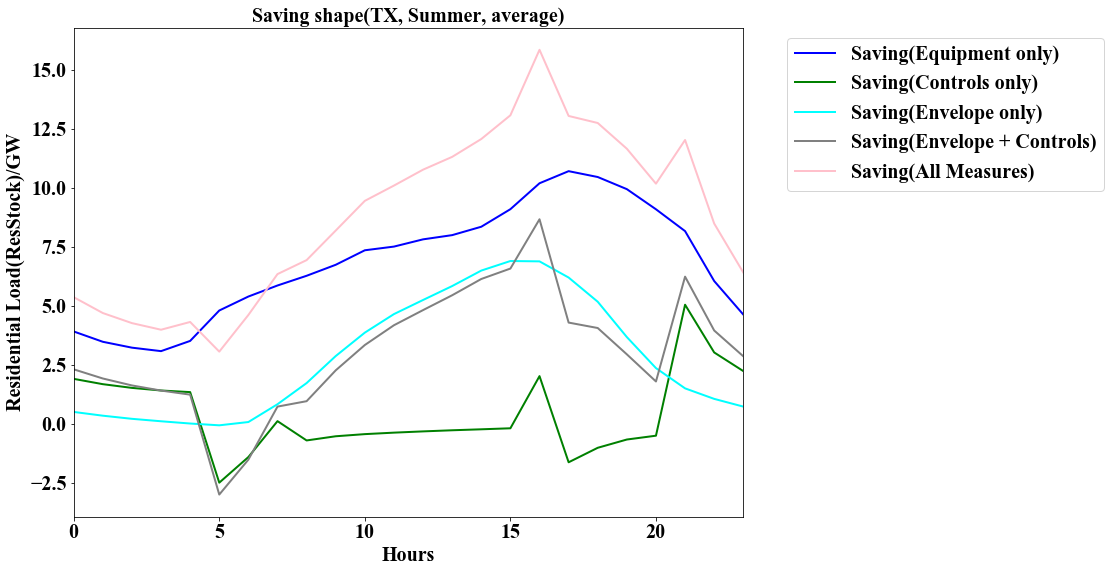

The season is: Fall


The season is: Winter


The season is: All year


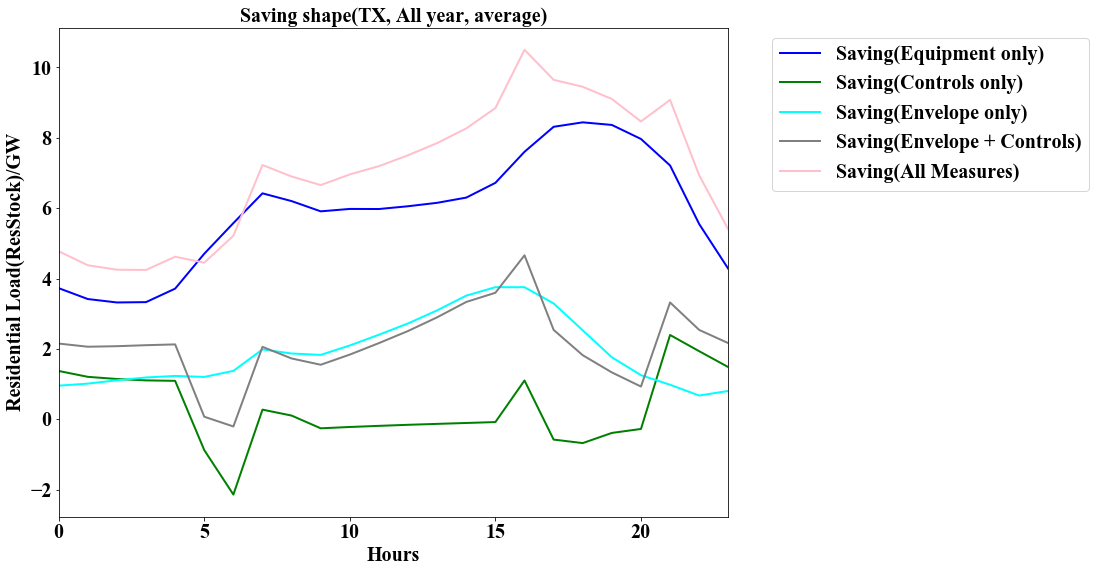

In [21]:
# formal launch
for Switch_peakday in [0]:
    for season in ['Spring','Summer','Fall','Winter','All year']:
#     for season in ['Spring']:
        if season == 'Spring':
            month_list = [3,4,5]
        elif season == 'Summer':
            month_list = [6,7,8]
        elif season == 'Fall':
            month_list = [9,10,11]
        elif season == 'Winter':
            month_list = [12,1,2] 
        print('The season is: ' + season)
        if season != 'All year':
            df_system_res_0 = pd.concat([df_system_res_0_raw[df_system_res_0_raw['month']==month_list[0]],df_system_res_0_raw[df_system_res_0_raw['month']==month_list[1]],df_system_res_0_raw[df_system_res_0_raw['month']==month_list[2]]])
            df_system_res_1 = pd.concat([df_system_res_1_raw[df_system_res_1_raw['month']==month_list[0]],df_system_res_1_raw[df_system_res_1_raw['month']==month_list[1]],df_system_res_1_raw[df_system_res_1_raw['month']==month_list[2]]])
            df_system_res_2 = pd.concat([df_system_res_2_raw[df_system_res_2_raw['month']==month_list[0]],df_system_res_2_raw[df_system_res_2_raw['month']==month_list[1]],df_system_res_2_raw[df_system_res_2_raw['month']==month_list[2]]])
            df_system_res_3 = pd.concat([df_system_res_3_raw[df_system_res_3_raw['month']==month_list[0]],df_system_res_3_raw[df_system_res_3_raw['month']==month_list[1]],df_system_res_3_raw[df_system_res_3_raw['month']==month_list[2]]])
            df_system_res_4 = pd.concat([df_system_res_4_raw[df_system_res_4_raw['month']==month_list[0]],df_system_res_4_raw[df_system_res_4_raw['month']==month_list[1]],df_system_res_4_raw[df_system_res_4_raw['month']==month_list[2]]])
            df_system_res_5 = pd.concat([df_system_res_5_raw[df_system_res_5_raw['month']==month_list[0]],df_system_res_5_raw[df_system_res_5_raw['month']==month_list[1]],df_system_res_5_raw[df_system_res_5_raw['month']==month_list[2]]])
            yearly_data_new = pd.concat([yearly_data[yearly_data['month']==month_list[0]],yearly_data[yearly_data['month']==month_list[1]],yearly_data[yearly_data['month']==month_list[2]]])

        else:
            df_system_res_0 = df_system_res_0_raw.copy()
            df_system_res_1 = df_system_res_1_raw.copy()
            df_system_res_2 = df_system_res_2_raw.copy()
            df_system_res_3 = df_system_res_3_raw.copy()
            df_system_res_4 = df_system_res_4_raw.copy()
            df_system_res_5 = df_system_res_5_raw.copy()
            yearly_data_new = yearly_data.copy()

        if Switch_peakday ==1:
            keyword = 'peakday'
            if Switch_onlyResLoad_peak ==1: # Only residential load peak hour
                df_system_res_0, day_id = peak_hourly_selection(df_system_res_0)
            elif  Switch_onlyResLoad_peak==0: # Total load peak hour   
                yearly_data_part, day_id = peak_hourly_selection(yearly_data_new)
                df_system_res_0 = df_system_res_0[df_system_res_0['day_continuous']==int(day_id)]
                total_except_res = list(map(lambda x: int(x[0])*1000-x[1], zip(yearly_data_part['Total'].tolist(), df_system_res_0['Total'].tolist())))
        
            df_system_res_1 = df_system_res_1[df_system_res_1['day_continuous']==int(day_id)]
            df_system_res_2 = df_system_res_2[df_system_res_2['day_continuous']==int(day_id)]
            df_system_res_3 = df_system_res_3[df_system_res_3['day_continuous']==int(day_id)]
            df_system_res_4 = df_system_res_4[df_system_res_4['day_continuous']==int(day_id)]
            df_system_res_5 = df_system_res_5[df_system_res_5['day_continuous']==int(day_id)]
        else:
            keyword = 'average'
            df_system_res_0 = df_system_res_0.groupby('hour').mean()
            df_system_res_1 = df_system_res_1.groupby('hour').mean()
            df_system_res_2 = df_system_res_2.groupby('hour').mean()
            df_system_res_3 = df_system_res_3.groupby('hour').mean()
            df_system_res_4 = df_system_res_4.groupby('hour').mean()
            df_system_res_5 = df_system_res_5.groupby('hour').mean() 
            df_system_res_0.index.names = ['index']
            df_system_res_1.index.names = ['index']
            df_system_res_2.index.names = ['index']
            df_system_res_3.index.names = ['index']
            df_system_res_4.index.names = ['index']
            df_system_res_5.index.names = ['index']
            df_system_res_0['hour'] = list(df_system_res_0.index)
            df_system_res_1['hour'] = list(df_system_res_1.index)
            df_system_res_2['hour'] = list(df_system_res_2.index)
            df_system_res_3['hour'] = list(df_system_res_3.index)
            df_system_res_4['hour'] = list(df_system_res_4.index)
            df_system_res_5['hour'] = list(df_system_res_5.index)


        title_name = 'Residential aggregation('+Region+', ' + season+', '+keyword+')' 


#         # Figure 1
#         figsize = 12,9
#         figure, ax = plt.subplots(figsize=figsize)
#         hours= [x for x in range(0,24)]
#         kW_GW_multip = 0.000001
#         A,=plt.plot(hours,df_system_res_0.groupby('hour').mean()['Total']*kW_GW_multip,color = 'black',label='Baseline',linewidth=2.0)
#         B,=plt.plot(hours,df_system_res_1.groupby('hour').mean()['Total']*kW_GW_multip,color = 'blue',label='Equipment only',linewidth=2.0)
#         C,=plt.plot(hours,df_system_res_2.groupby('hour').mean()['Total']*kW_GW_multip,color = 'green',label='Controls only',linewidth=2.0)
#         D,=plt.plot(hours,df_system_res_3.groupby('hour').mean()['Total']*kW_GW_multip,color = 'cyan',label='Envelope only',linewidth=2.0)
#         E,=plt.plot(hours,df_system_res_4.groupby('hour').mean()['Total']*kW_GW_multip,color = 'grey',label='Envelope + Controls',linewidth=2.0)
#         F,=plt.plot(hours,df_system_res_5.groupby('hour').mean()['Total']*kW_GW_multip,color = 'pink',label='All Measures',linewidth=2.0)

#         font1 = {'family' : 'Times New Roman',
#         'weight' : 'normal',
#         'size'   : 20,
#         }
#         font2 = {'family' : 'Times New Roman',
#         'weight' : 'normal',
#         'size'   : 20,
#         }
#         # legend = plt.legend(handles=[A,B,C,D],prop=font1, bbox_to_anchor=[1.04,1])
#         legend = plt.legend(handles=[A,B,C,D,E,F],bbox_to_anchor=[1.05,1],prop=font1,)

#         plt.tick_params(labelsize=20)
#         labels = ax.get_xticklabels() + ax.get_yticklabels()
#         [label.set_fontname('Times New Roman') for label in labels]

#         plt.xlabel('Hours',font2)
#         plt.ylabel('Residential Load(ResStock)/GW',font2)
#         plt.title(title_name,font1)
#         plt.xlim((0, 23)) 
#         plt.show()
#         figure.savefig(os.path.join(outdir,'Outputs/Images/Load_curve_in_all_scenarios_{g}_{r}.png'.format(g=season,r = keyword)),dpi=300)


        # Figure 1(saving shape)
        title_name = 'Saving shape('+Region+', ' + season+', '+keyword+')' 
        figsize = 12,9
        figure, ax = plt.subplots(figsize=figsize)
        hours= [x for x in range(0,24)]
        kW_GW_multip = 0.000001
#         A,=plt.plot(hours,df_system_res_0.groupby('hour').mean()['Total']*kW_GW_multip,color = 'black',label='Baseline',linewidth=2.0)
        B,=plt.plot(hours,list(map(lambda x: x[0]-x[1], zip(list(df_system_res_0.groupby('hour').mean()['Total']*kW_GW_multip),list(df_system_res_1.groupby('hour').mean()['Total']*kW_GW_multip)))),color = 'blue',label='Saving(Equipment only)',linewidth=2.0)
        C,=plt.plot(hours,list(map(lambda x: x[0]-x[1], zip(list(df_system_res_0.groupby('hour').mean()['Total']*kW_GW_multip),list(df_system_res_2.groupby('hour').mean()['Total']*kW_GW_multip)))),color = 'green',label='Saving(Controls only)',linewidth=2.0)
        D,=plt.plot(hours,list(map(lambda x: x[0]-x[1], zip(list(df_system_res_0.groupby('hour').mean()['Total']*kW_GW_multip),list(df_system_res_3.groupby('hour').mean()['Total']*kW_GW_multip)))),color = 'cyan',label='Saving(Envelope only)',linewidth=2.0)
        E,=plt.plot(hours,list(map(lambda x: x[0]-x[1], zip(list(df_system_res_0.groupby('hour').mean()['Total']*kW_GW_multip),list(df_system_res_4.groupby('hour').mean()['Total']*kW_GW_multip)))),color = 'grey',label='Saving(Envelope + Controls)',linewidth=2.0)
        F,=plt.plot(hours,list(map(lambda x: x[0]-x[1], zip(list(df_system_res_0.groupby('hour').mean()['Total']*kW_GW_multip),list(df_system_res_5.groupby('hour').mean()['Total']*kW_GW_multip)))),color = 'pink',label='Saving(All Measures)',linewidth=2.0)

        font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 20,
        }
        font2 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 20,
        }
        # legend = plt.legend(handles=[A,B,C,D],prop=font1, bbox_to_anchor=[1.04,1])
        legend = plt.legend(handles=[B,C,D,E,F],bbox_to_anchor=[1.05,1],prop=font1,)

        plt.tick_params(labelsize=20)
        labels = ax.get_xticklabels() + ax.get_yticklabels()
        [label.set_fontname('Times New Roman') for label in labels]

        plt.xlabel('Hours',font2)
        plt.ylabel('Residential Load(ResStock)/GW',font2)
        plt.title(title_name,font1)
        plt.xlim((0, 23)) 
        plt.show()
        figure.savefig(os.path.join(outdir,'Outputs/Images/Load_curve_in_all_scenarios_{g}_{r}.png'.format(g=season,r = keyword)),dpi=300)
        
# # Figure 2
#         kwh_TO_GWh = 0.000001

#         if season == 'All year':
#             result_com = pd.DataFrame()

#             for upgrade in ['Baseline','Equipment only','Controls only','Envelope only','Envelope + Controls','All Measures']:
#                 if upgrade == 'Baseline':
#                     df_system_com = df_system_res_0.copy()
#                 elif upgrade == 'Equipment only':
#                     df_system_com = df_system_res_1.copy()
#                 elif upgrade == 'Controls only':
#                     df_system_com = df_system_res_2.copy()
#                 elif upgrade == 'Envelope only':
#                     df_system_com = df_system_res_3.copy()
#                 elif upgrade == 'Envelope + Controls':
#                     df_system_com = df_system_res_4.copy()
#                 elif upgrade == 'All Measures':
#                     df_system_com = df_system_res_5.copy()        
#                 sum_list = []

#                 for k in df_system_res_0.columns.tolist()[0:]:
#                     sum_list.append(df_system_com[k].sum())

#                 sum_list = [x*kwh_TO_GWh for x in sum_list]    
#                 result_com[upgrade] = sum_list
#             enduse_list = [x for x in df_system_res_0.columns.tolist()[0:]]
#             result_com.index = enduse_list

#             result1 = result_com.drop(index='Total')
#             result = result1.drop(index='EXCLUDE')

#             zero_env=False
#             fig, axs = plt.subplots(2,1, figsize=[12,10], sharex=True)
#             if Region == 'CA':
#                 rs_map = {'CAMX':'CA', 'ERCT':'TX'}
#             elif Region == 'TX':
#                 rs_map = {'CAMX':'TX', 'ERCT':'TX'}
#             if Region == 'NewEngland':
#                 rs_map = {'CAMX':'NewEngland', 'ERCT':'TX'}
                
#             plot_ports = ['Baseline','Equipment only','Controls only','Envelope only','Envelope + Controls','All Measures']
#             outdir = os.path.abspath(os.getcwd())
#             for ax, reg in zip(axs, ['ERCT','CAMX']):
#                 features = result.copy()
#                 features = features.drop(index=['month','day','hour','day_continuous'])
#                 features[plot_ports].T.plot.bar(stacked=True, legend=False, cmap=plt.cm.get_cmap('tab20'), edgecolor='k', 
#                                     fontsize=16, grid=False,
#                                     ax=ax)
#                 ax.set_ylabel('End use load (GWh)', fontsize=16)
#                 ax.text(1.01, 0.9, rs_map[reg], transform=ax.transAxes, fontsize=20, fontweight='bold')

#             axs[1].legend(loc='lower left', bbox_to_anchor=[1.05,-0.1], fontsize=14)
#             if Switch_peakday ==1:
#                 plt.title('features agg by enduse(residential, '+Region+', ' + season+ ', peakday)' ,fontsize=18)
#             else:
#                 plt.title('features agg by enduse(residential, '+Region+', ' + season+ ', average)' ,fontsize=18)       
#             plt.tight_layout()
#             fig.savefig(os.path.join(outdir,'Outputs/Images/Annual_load_agg_by_{g}_{d}_{r}.png'.format(g='end_use',d=keyword,r='CA')),dpi=300)

        
# # Figure 3
#         fig, axes = plt.subplots(2,3, figsize=(18,12))
#         for upgrade in ['Equipment only','Controls only','Envelope only','Envelope + Controls','All Measures']:
#             print(upgrade)
#             if upgrade == 'Equipment only':
#                 df_system_com = df_system_res_1.copy()
#                 count = 1
#             elif upgrade == 'Controls only':
#                 df_system_com = df_system_res_2.copy()
#                 count = 2
#             elif upgrade == 'Envelope only':
#                 df_system_com = df_system_res_3.copy()
#                 count = 3
#             elif upgrade == 'Envelope + Controls':
#                 df_system_com = df_system_res_4.copy()
#                 count = 4
#             elif upgrade == 'All Measures':
#                 df_system_com = df_system_res_5.copy()     
#                 count = 5

#             sum_list = []
#             df_saving_res = pd.DataFrame()
#             for enduse in df_system_res_0.columns.tolist()[0:-2]:
#                 df_saving_res[enduse] = list(map(lambda x: x[0]-x[1], zip(df_system_res_0[enduse].tolist(), df_system_com[enduse].tolist())))

#             df_saving_res['hour'] = df_system_res_0['hour'].tolist()
#             df_saving_res = df_saving_res.drop(columns=['Total','EXCLUDE'])

#             df_saving_res = df_saving_res.drop(columns = ['hour','day','month'])    
#             df_saving_res_GW = df_saving_res*kW_GW_multip        

#             ax=axes[int((count-1)/3),((count-1)%3)]

#             total = df_saving_res_GW.sum(axis=1)        
#             df_saving_res_GW.plot.bar(ax=ax,stacked=True, width=1)
#             ax.step(np.arange(24), list(total.values),color='k', label='Total', where='mid') 

#             ax.set_title(upgrade,fontsize=14)
#             x_list = []
#             for x in range(24):
#                 if x%3==0:
#                     x_list.append(x)
#                 else:
#                     x_list.append('')
#             ax.set_xticklabels(x_list, rotation=0)
#             ax.set_xticklabels(x_list, fontsize=14) 

# #             if Switch_peakday ==0: # average
# #                 range_l = -2
# #                 range_u = 8
# #                 number = 6
# #             elif Switch_peakday ==1:
# #                 range_l = -2
# #                 range_u = 10
# #                 number = 7
#             if count ==1 and Region =='TX' and season == 'Winter':        
#                 if Switch_peakday ==0: # average
#                     range_l = -2
#                     range_u = (int(max(list(total.values))/2)+1)*2
#                     number = range_u/2+2
#                 elif Switch_peakday ==1:
#                     range_l = -4
#                     range_u = 24
#                     number = range_u/4+2
#             elif count ==1 and Region =='TX' and season == 'All year':        
#                 if Switch_peakday ==0: # average
#                     range_l = -2
#                     range_u = (int(max(list(total.values))/2)+1)*2
#                     number = range_u/2+2
#                 elif Switch_peakday ==1:
#                     range_l = -4
#                     range_u = 20
#                     number = range_u/4+2
#             elif count ==1:        
#                 if Switch_peakday ==0: # average
#                     range_l = -2
#                     range_u = (int(max(list(total.values))/2)+1)*2
#                     number = range_u/2+2
#                 elif Switch_peakday ==1:
#                     range_l = -2
#                     range_u = (int(max(list(total.values))/2)+1)*2
#                     number = range_u/2+2
                
#             y_list = np.linspace(range_l,range_u,number)
#             ax.set_ylim([range_l, range_u])
#             ax.set_yticks(y_list) 
#             ax.set_yticklabels(y_list, fontsize=14) 
#             if count % 3  ==1: 
#                 ax.set_ylabel('Hourly energy savings(GWh)',fontsize=14)
#             if count > 3: 
#                 ax.set_xlabel('Hour (h)',fontsize=16)
#             if count ==5:
#                 ax.legend(bbox_to_anchor=(1.5,0.75), loc='upper left',prop={'size': 14})
#             else:
#                 ax.legend(bbox_to_anchor=(0.5,-3), loc='upper left',prop={'size': 14})
#             if count == 1:
#                 plt.subplot(2,3,6)
#                 plt.plot([0,0],[0,0])
#                 plt.xticks([])
#                 plt.yticks([])
#                 plt.axis('off') 
                
# # Figure 4
#         fig, axes = plt.subplots(2,3, figsize=(18,12))
#         for upgrade in ['Equipment only','Controls only','Envelope only','Envelope + Controls','All Measures']:
#             print(upgrade)
#             if upgrade == 'Equipment only':
#                 df_system_com = df_system_res_1.copy()
#                 count = 1
#             elif upgrade == 'Controls only':
#                 df_system_com = df_system_res_2.copy()
#                 count = 2
#             elif upgrade == 'Envelope only':
#                 df_system_com = df_system_res_3.copy()
#                 count = 3
#             elif upgrade == 'Envelope + Controls':
#                 df_system_com = df_system_res_4.copy()
#                 count = 4
#             elif upgrade == 'All Measures':
#                 df_system_com = df_system_res_5.copy()     
#                 count = 5

#             sum_list = []
#             df_saving_res = pd.DataFrame()
#             for enduse in df_system_res_0.columns.tolist()[0:-2]:
#                 df_saving_res[enduse] = list(map(lambda x: x[0]-x[1], zip(df_system_res_0[enduse].tolist(), df_system_com[enduse].tolist())))

#             df_saving_res['hour'] = df_system_res_0['hour'].tolist()
#             df_saving_res = df_saving_res.drop(columns=['Total','EXCLUDE'])

#             df_saving_res = df_saving_res.drop(columns = ['hour','day','month'])    
#             df_saving_res_GW = df_saving_res*kW_GW_multip        

#             ax=axes[int((count-1)/3),((count-1)%3)]
            

#             df_base_list = [x*kwh_TO_GWh for x in df_system_res_0['Total'].tolist()]
#             df_upgr_list = [x*kwh_TO_GWh for x in df_system_com['Total'].tolist()]
#             if Switch_onlyResLoad_peak ==0 and Switch_bottom_onlyResEE ==0:
#                 df_base_list = list(map(lambda x: x[0]+x[1]*kW_GW_multip , zip(df_base_list,total_except_res)))
#                 df_upgr_list = list(map(lambda x: x[0]+x[1]*kW_GW_multip , zip(df_upgr_list,total_except_res)))
            
#             df_saving_res_GW.plot.bar(stacked=True, ax=ax, width=1, bottom=df_upgr_list)
#             ax.step(np.arange(24), df_base_list,
#                     color='k', label='Baseline', where='mid')
#             ax.step(np.arange(24), df_upgr_list,
#                     color='k',linestyle=':', label='EE', where='mid')  

#             ax.set_title(upgrade,fontsize=14)
#             x_list = []
#             for x in range(24):
#                 if x%3==0:
#                     x_list.append(x)
#                 else:
#                     x_list.append('')
#             ax.set_xticklabels(x_list, rotation=0)
#             ax.set_xticklabels(x_list, fontsize=14) 

# #             if Switch_peakday ==0: # average
# #                 range_l = 0
# #                 range_u = 16
# #                 number = 9
# #             elif Switch_peakday ==1:
# #                 range_l = 0
# #                 range_u = 20
# #                 number = 6
                
#             if Switch_peakday ==0: # average
#                 range_l = 0
#                 range_u = (int(max(df_base_list)/4)+1)*4
#                 number = range_u/4+1
#             elif Switch_peakday ==1:
#                 range_l = 0
#                 range_u = (int(max(df_base_list)/4)+1)*4
#                 number = range_u/4+1
#                 if number <=4:
#                     range_l = 0
#                     range_u = (int(max(df_base_list)/2)+1)*2
#                     number = range_u/2+1                

#             y_list = np.linspace(range_l,range_u,number)
#             ax.set_ylim([range_l, range_u])
#             ax.set_yticks(y_list) 
#             ax.set_yticklabels(y_list, fontsize=14) 
         
#             if count % 3  ==1: 
#                 ax.set_ylabel('Hourly energy consumption (GWh)',fontsize=14)
#             if count > 3: 
#                 ax.set_xlabel('Hour (h)',fontsize=16)
#             if count ==5:
#                 ax.legend(bbox_to_anchor=(1.5,0.75), loc='upper left',prop={'size': 14})
#             else:
#                 ax.legend(bbox_to_anchor=(0.5,-3), loc='upper left',prop={'size': 14})
#             if count == 1:
#                 plt.subplot(2,3,6)
#                 plt.plot([0,0],[0,0])
#                 plt.xticks([])
#                 plt.yticks([])
#                 plt.axis('off') 


In [22]:
df_system_res_0

Appliances       Cooling       EXCLUDE       Heating      Lighting  \
index                                                                         
0      1.322438e+06  2.610967e+06  3.488576e+06  1.582467e+06  3.826327e+05   
1      1.163887e+06  2.307134e+06  3.249782e+06  1.731585e+06  2.431076e+05   
2      1.071703e+06  2.072171e+06  3.129543e+06  1.940015e+06  2.071650e+05   
3      1.059678e+06  1.907966e+06  3.044430e+06  2.114779e+06  2.140519e+05   
4      1.089873e+06  1.891979e+06  3.176027e+06  2.264726e+06  4.509145e+05   
5      1.359488e+06  2.079742e+06  3.780382e+06  2.311300e+06  1.088624e+06   
6      1.583293e+06  2.003529e+06  4.300514e+06  2.593840e+06  1.611559e+06   
7      2.073078e+06  2.334175e+06  4.589240e+06  3.366641e+06  1.755786e+06   
8      2.815164e+06  2.667140e+06  4.859903e+06  2.455596e+06  1.764101e+06   
9      2.761511e+06  3.576100e+06  4.659561e+06  1.530380e+06  1.745375e+06   
10     2.825457e+06  4.493390e+06  4.762935e+06  1.122731e+06  1.680867e+06   
11     2.775268e+06  5.386621e+06  4.690127e+06  8.342483e+05  1.621647e+06   
12     2.671903e+06  6.192183e+06  4.598280e+06  6.473526e+05  1.592923e+06   
13     2.523689e+06  7.047139e+06  4.558899e+06  5.205129e+05  1.586990e+06   
14     2.318935e+06  7.933987e+06  4.447249e+06  4.322904e+05  1.594311e+06   
15     2.567400e+06  8.677352e+06  4.984754e+06  4.038593e+05  1.636463e+06   
16     3.007500e+06  1.009248e+07  6.003208e+06  4.149716e+05  1.781436e+06   
17     3.147697e+06  9.273895e+06  6.642034e+06  6.257971e+05  2.136209e+06   
18     2.804247e+06  7.839902e+06  6.574810e+06  6.405267e+05  2.717531e+06   
19     2.585749e+06  6.223450e+06  6.538528e+06  7.560821e+05  3.303398e+06   
20     2.303378e+06  4.993171e+06  6.257533e+06  9.331085e+05  3.543842e+06   
21     2.167881e+06  4.985162e+06  5.720500e+06  1.111605e+06  2.699313e+06   
22     1.832605e+06  3.931729e+06  4.857189e+06  9.540226e+05  1.535948e+06   
23     1.500441e+06  3.043593e+06  3.994333e+06  1.257827e+06  7.001280e+05   

               Other    Plug Loads         Total  Water Heating     month  \
index                                                                       
0      239809.032183  1.926328e+06  8.524051e+06   4.594087e+05  6.513661   
1      221311.450657  1.864584e+06  7.830334e+06   2.987263e+05  6.513661   
2      223069.878761  1.834771e+06  7.565073e+06   2.161775e+05  6.513661   
3      260000.701846  1.724752e+06  7.522093e+06   2.408655e+05  6.513661   
4      333709.088779  1.752445e+06  8.237130e+06   4.534839e+05  6.513661   
5      398016.468771  2.022877e+06  1.018438e+07   9.243342e+05  6.513661   
6      431022.737468  2.286199e+06  1.195219e+07   1.442748e+06  6.513661   
7      535200.044600  1.980962e+06  1.377231e+07   1.726468e+06  6.513661   
8      659275.810721  1.385463e+06  1.349890e+07   1.752164e+06  6.513661   
9      709172.567099  1.188878e+06  1.321172e+07   1.700299e+06  6.513661   
10     698206.152753  1.239272e+06  1.361669e+07   1.556768e+06  6.513661   
11     684818.370901  1.230041e+06  1.394098e+07   1.408335e+06  6.513661   
12     597666.918133  1.328710e+06  1.429416e+07   1.263418e+06  6.513661   
13     534736.346113  1.500474e+06  1.478372e+07   1.070176e+06  6.513661   
14     536282.791208  1.592031e+06  1.534431e+07   9.364764e+05  6.513661   
15     596054.017376  1.821301e+06  1.662929e+07   9.268598e+05  6.513661   
16     612959.936346  2.382747e+06  1.931664e+07   1.024550e+06  6.513661   
17     525321.734320  2.969015e+06  1.994469e+07   1.266757e+06  6.513661   
18     476481.395141  3.294082e+06  1.924991e+07   1.477136e+06  6.513661   
19     457120.613861  3.495658e+06  1.834571e+07   1.524249e+06  6.513661   
20     435795.152450  3.518360e+06  1.714757e+07   1.419919e+06  6.513661   
21     373547.823994  3.179071e+06  1.578484e+07   1.268261e+06  6.513661   
22     319641.902699  2.704942e+06  1.229039e+07   1.011503e+06  6.513661   
23     272342.516394  2.22154

In [23]:
yearly_data_part['Total'].tolist()
df_system_res_0['Total'].tolist()

NameError: name 'yearly_data_part' is not defined

In [ ]:
a = [1,2,3]
b = [1,2,3]
a = list(map(lambda x: x[0]+x[1], zip(a,b)))
a

In [ ]:
ENDUSE_MAPPING_DICT = {'cooling': 'hvac'}
ENDUSE_MAPPING_DICT_full = {'cooling': 'hvac', 'Heating': 'heating','Central_System_Heating': 'hvac','Cooling': 'hvac', 
                'Central_System_Cooling': 'hvac','Water_Heating': 'waterheating','Heating_Fans': 'hvac',
                'Cooling_Fans': 'hvac','Heating_pumps': 'hvac', 'Cooling_Pumps': 'hvac',
                'Central_System_Heating_Pumps': 'hvac','Central_System_Cooling_Pumps': 'hvac',
                'House_Fan': 'hvac','Ceiling_Fan': 'hvac','Hot_Tub_Heater_Electric': 'waterheating', 
                'Pool_Heater_Electric': 'waterheating', 'Pool_Pump': 'poolpump',
                'exterior-lighting': 'lighting','fans': 'hvac','heat-recovery': 'hvac',
                'heat-rejection':'hvac','heating': 'hvac','interior-lighting': 'lighting',
                'pumps': 'pump','refrigeration': 'refrigeration','water-systems': 'pump'}  

In [ ]:
eu = 'cooling'
if eu in ENDUSE_MAPPING_DICT.keys():
    eu_name = ENDUSE_MAPPING_DICT[eu]
    print(eu_name)